In [1]:
# imports and setting up file IO

import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

os.environ['KERAS_BACKEND'] = 'tensorflow'
#from keras import layers
from keras.layers import * #Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
#from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import * #Model, load_model
from vis.visualization import visualize_cam 
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2, l1_l2

data_folder = r"C:\Users\PerkLab\Desktop\HerniaAnnotationData-2019-10-30"
notebook_save_folder = r"C:\Users\PerkLab\Desktop\HerniaAnnotationSavedNotebooks"
model_save_folder = r"C:\Users\PerkLab\Desktop\HerniaAnnotationSavedModels"

ultrasound_file = r"x_train_fourthSixthSeventh_128_NoNone.npy"
segmentation_file = r"y_train_fourthSixthSeventh_128_NoNone.npy" 
prediction_file=r""

test_ultrasound_file = r"x_train_fifth_128_NoNone.npy"
test_segmentation_file = r"y_train_fifth_128_NoNone.npy"
test_prediction_file=r"prediction-test.npy"

ultrasound_size = 128
 
model_to_validate_path = r"C:\Users\PerkLab\Documents\HerniaModelStudy\SavedModels\model_2019-07-30_00-09-33.h5"

train_model = True

classes = ['None', 'Skin', 'Fat', 'Extob', 'Spchd', 'Sack']
classes = ['None', 'Extob', 'Fat', 'Sack', 'Skin', 'Spchd']
classes = ['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']

resized_image_size = 128

# if not os.path.exists(training_data_path):
#     print("Could not find folder: " + training_data_path)
#     raise

# if not os.path.exists(testing_data_path):
#     print("Could not find folder: {}".format(testing_data_path))
#     raise
    
# if not os.path.exists(validation_data_path):
#     print("Could not find folder: {}".format(validation_data_path))
#     raise
    
# if not os.path.exists(second_validation_data_path):
#     print("Could not find folder: {}".format(second_validation_data_path))
#     raise


Using TensorFlow backend.


In [2]:
ultrasound_fullname = os.path.join(data_folder, ultrasound_file)
segmentation_fullname = os.path.join(data_folder, segmentation_file)

print("Reading images from:  {}".format(ultrasound_fullname))
print("Reading labels from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))


Reading images from:  C:\Users\PerkLab\Desktop\HerniaAnnotationData-2019-10-30\x_train_fourthSixthSeventh_128_NoNone.npy
Reading labels from:      C:\Users\PerkLab\Desktop\HerniaAnnotationData-2019-10-30\y_train_fourthSixthSeventh_128_NoNone.npy

Found 83041 ultrasound images and 83041 segmentations


Reading test ultrasound from: C:\Users\PerkLab\Desktop\HerniaAnnotationData-2019-10-30\x_train_fifth_128_NoNone.npy
Reading test segmentation from : C:\Users\PerkLab\Desktop\HerniaAnnotationData-2019-10-30\y_train_fifth_128_NoNone.npy

Found 27894 test ultrasound images and 27894 segmentations
(128, 128, 3)


Text(0.5, 1.0, '0.0')

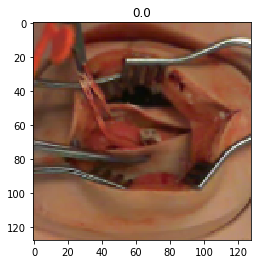

In [3]:
test_ultrasound_fullname = os.path.join(data_folder, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_folder, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname) 
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))
print(test_ultrasound_data[0].shape)

imgplot = plt.imshow(test_ultrasound_data[110]/255.0)
plt.title(str(test_segmentation_data[110]))

In [4]:
import keras.utils
import scipy.ndimage


max_rotation_angle = 60
max_brightness_factor = 0.25 # adds or subtracts 20%

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=3,
                 n_classes=len(classes),
                 isTrain=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        self.isTrain = isTrain
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        if self.isTrain:
            return int(np.floor(self.number_of_images / self.batch_size / 1))
        else:
            return int(np.floor(self.number_of_images / self.batch_size))

    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size)) # removed dim
#         print("x.shape is {}".format(str(x.shape)))
#         print(x)
        for i in range(self.batch_size):
            
            flip_flag = np.random.randint(2) 
            if flip_flag == 1 and self.isTrain: # TODO investigate the flip...
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                #y[i] = np.flip(self.y[batch_indexes[i]]) # removed 2 ,; from each slice operation # changede axis 1 to 0
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
            y[i] = self.y[batch_indexes[i]] # removed 2 ,: from each slice operation
            
            if self.isTrain:
                brightness_multiplier = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i, :,:,:] = brightness_multiplier * x[i, :, :, :]
#         print("x.shape is {} after flip".format(str(x.shape)))
#         print(x)
        if self.isTrain:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        else:
            angle = 0
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
        #y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
#         print("x_rot.shape is {} after rotation".format(str(x_rot.shape)))
#         print(x_rot)
        y_rot = y
        
        x_rot = x_rot / 255.0
        x_rot = np.clip(x_rot, 0.0, 1.0)
        #y_rot = np.clip(y_rot, 0.0, 1.0)
#         print("x_rot.shape is {} after clipping".format(str(x_rot.shape)))
#         print(x_rot)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

(32, 5)
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


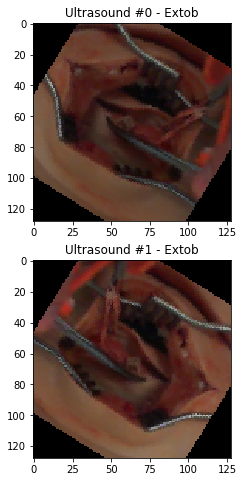

In [5]:
#testing batch generator

batch_size = 32
num_show = 2

tgen = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_data, batch_size, shuffle=False, isTrain=True)

bx, by = tgen.__getitem__(3)

print(by.shape)

import matplotlib.pyplot as plt

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show,3,i*3+1)
    img1 = a1.imshow(bx[i, :, :, :]) #, vmin=0.0, vmax=1.0)
    a1.set_title("Ultrasound #{} - {}".format(i, classes[np.argmax(by[i])]))
    print(by[i])

In [6]:
model = Sequential()
model.add(Conv2D(16, (2,2),  input_shape=(resized_image_size, resized_image_size, 3), activation='relu'))
model.add(Conv2D(16, (2,2), activation='relu'))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(256, (2,2), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(256))
#model.add(BatchNormalization())
#model.add(PReLU())
model.add(Dropout(0.25))

model.add(Dense(len(classes)))
model.add(Activation('softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 127, 16)      208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 16)      1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 32)        2080      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        8256      
__________

In [8]:
# train the model
from keras.callbacks import EarlyStopping


if train_model:
    
    batch_size = 32
    
    num_epochs = 30

    earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(os.path.join(model_save_folder, 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5'), save_best_only=True, monitor='val_loss', mode='min')
    
    model.compile(optimizer = SGD(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_data, batch_size, isTrain=True)
    test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data, batch_size, isTrain=False)

    training_time_start = datetime.datetime.now()

    history = model.fit_generator(training_generator,
                                       validation_data=test_generator,
                                       epochs=num_epochs,
                                       verbose=1, 
                                       callbacks=[mcp_save])
    
else:
    print("Training skipped, using loaded model. ")

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2595/2595 [==============================] - 249s 96ms/step - loss: 1.6087 - acc: 0.2110 - val_loss: 1.6025 - val_acc: 0.2024
Epoch 2/30
2595/2595 [==============================] - 240s 92ms/step - loss: 1.3627 - acc: 0.4043 - val_loss: 0.7840 - val_acc: 0.7327
Epoch 3/30
2595/2595 [==============================] - 243s 94ms/step - loss: 0.6223 - acc: 0.7736 - val_loss: 0.3742 - val_acc: 0.8777
Epoch 4/30
2595/2595 [==============================] - 241s 93ms/step - loss: 0.3830 - acc: 0.8629 - val_loss: 0.3338 - val_acc: 0.8731
Epoch 5/30
2595/2595 [==============================] - 240s 93ms/step - loss: 0.2858 - acc: 0.8982 - val_loss: 0.1924 - val_acc: 0.9285
Epoch 6/30
2595/2595 [==============================] - 245s 95ms/step - loss: 0.2264 - acc: 0.9192 - val_loss: 0.1801 - val_acc: 0.9364
Epoch 7/30
2595/2595 [==============================] - 244s 94ms/step - loss: 0.1892 - acc: 0.9340 - val_loss: 0.1406 - val_acc: 

In [9]:
# print out time info
if train_model:
    training_time_stop = datetime.datetime.now()
    print("Training started at: {}".format(training_time_start))
    print("Training stopped at: {}".format(training_time_stop))
    print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-11-01 12:40:35.321712
Training stopped at: 2019-11-01 14:41:01.078434
Total training time: 2:00:25.756722


In [10]:
print(history)

(128, 128, 3)
(1, 128, 128, 3)
[0.73333333 0.54901961 0.45882353]
[0.73333333 0.54901961 0.45882353]
float64
(1, 5)
float32
['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']
[[9.9999022e-01 9.8808762e-08 7.4984091e-06 8.2363799e-10 2.1609549e-06]]
(128, 128, 3)
(1, 128, 128, 3)
[0.7372549  0.58039216 0.45490196]
[0.7372549  0.58039216 0.45490196]
float64
(1, 5)
float32
['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']
[[1.1236131e-05 9.9998534e-01 5.0290055e-10 3.4592442e-06 2.0794841e-10]]
(128, 128, 3)
(1, 128, 128, 3)
[0.73333333 0.57647059 0.45098039]
[0.73333333 0.57647059 0.45098039]
float64
(1, 5)
float32
['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']
[[8.9287917e-12 1.0000000e+00 1.6852252e-17 9.0814432e-09 9.6952433e-18]]
(128, 128, 3)
(1, 128, 128, 3)
[0.7372549  0.58039216 0.45490196]
[0.7372549  0.58039216 0.45490196]
float64
(1, 5)
float32
['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']
[[1.1236131e-05 9.9998534e-01 5.0290055e-10 3.4592442e-06 2.0794841e-10]]
(128, 128, 3)
(1, 128, 128, 3)
[0.792156

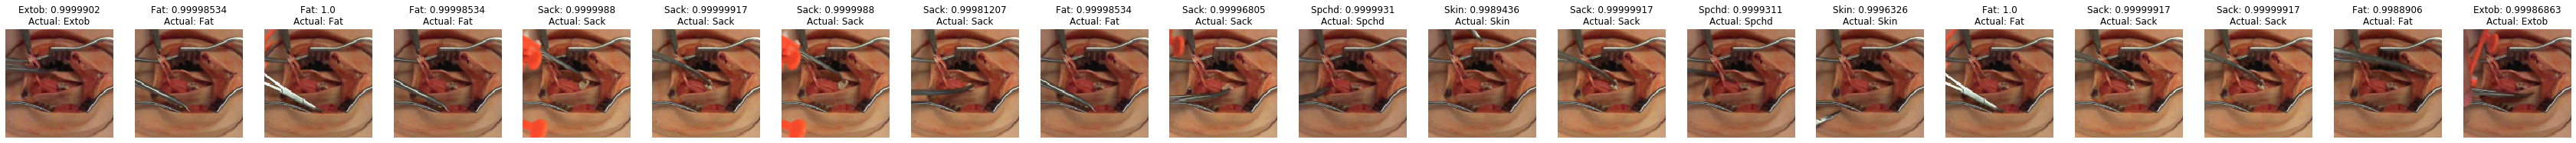

In [11]:
# show some results

#test_generator.reset()
x,y = test_generator.__getitem__(25)

num_choices = 20
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices): # TODO look into the negative numbers!!
    im = x[random_choice[i]][:,:,:] 
    
    im_exp = np.expand_dims(im, 0)
    print(im.shape)
    print(im_exp.shape)
    print(im[127][127])
    print(im_exp[0][127][127])
    print(im_exp.dtype)
    prediction = model.predict(im_exp)
    print(prediction.shape)
    print(prediction.dtype)
    print(classes)
    print(prediction)
    plt.subplot(1, num_choices, i+1)
    max_index = np.argmax(prediction[0])
    plt.title(str(classes[max_index]) + ": " + str(prediction[0][max_index]) + "\nActual: " + str(classes[np.argmax(y[random_choice[i]])]))
    #plt.imshow((im + 1)/2)
    plt.imshow(im)
    plt.axis('off')
    
val_x = x
val_y = y

model.summary()

There were 24 correct out of 25 for an accuracy of 96.0%


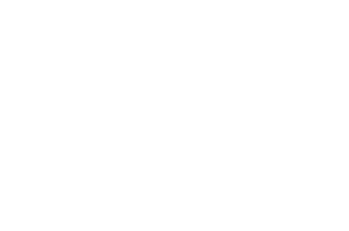

In [12]:
# show some more results
# TODO working on getting it to show an array of subplots. 

#test_generator.reset()

#plt.figure(figsize=(3*num_choices, 3))

w=10
h=10
fig=plt.figure(figsize=(128, 128), tight_layout=True)
cols=5
rows=5

num_choices = cols

sample_total = 0
sample_correct = 0

for row in range(1, rows + 1):
    x,y = test_generator.__getitem__(5*row)
    test_indices = range(batch_size)
    random_choice = np.random.choice(test_indices, num_choices)
    for col in range(1, cols + 1):
        img = x[random_choice[col-1]][:,:,:]
        #print(img.shape)
        #img = np.random.randint(10, size=(w,h))
        #prediction = model.predict(np.expand_dims(img, 0))
        prediction = model.predict(np.expand_dims(img, 0))
        max_index = np.argmax(prediction[0])
        predicted_label = str(classes[max_index])
        confidence = str(prediction[0][max_index])
        correct_label = classes[np.argmax(y[random_choice[col-1]])]
        text = predicted_label + ": " + confidence + "\nActual: " + correct_label
        place = cols*(row-1) + col
        ax = fig.add_subplot(rows, cols, place, label=str(place))
        ax.set_title(text, size=180)
        plt.imshow(img)
        if str(predicted_label) == str(correct_label):
            sample_correct+=1
        sample_total+=1
        # print("row {}, col {}".format(row, col))
plt.show()
plt.axis('off')

if sample_total!=0:
    print("There were {} correct out of {} for an accuracy of {}%".format(sample_correct, sample_total, sample_correct/sample_total*100))
    
val_x = x
val_y = y

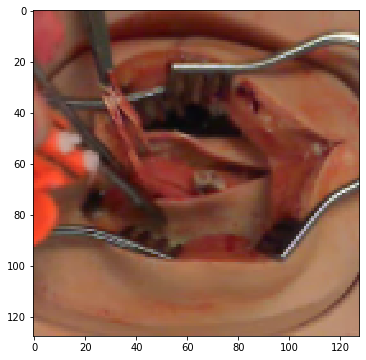

In [13]:
class_idx = 0
indices = np.where(val_y[:, class_idx] == 1.)[0]

# pick some random input from here
idx = indices[0]

# check picked image

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(val_x[idx][...])

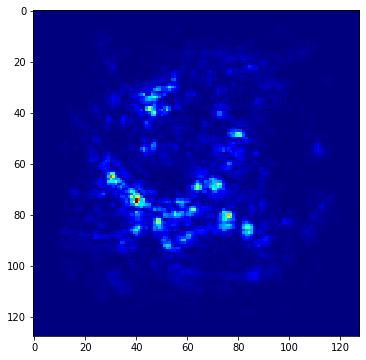

In [14]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# utility ot search for layer index by name
# or we could specify -1 for last layer. 

layer_idx = -1

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices = class_idx, seed_input=val_x[idx])
# plot with jet colormap to visualize  as heatmap
plt.imshow(grads, cmap='jet')

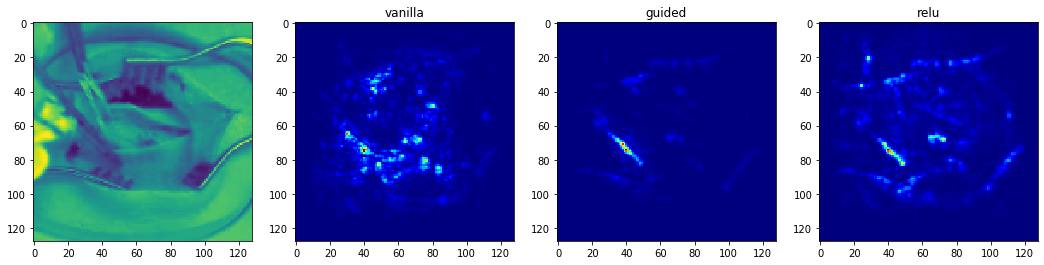

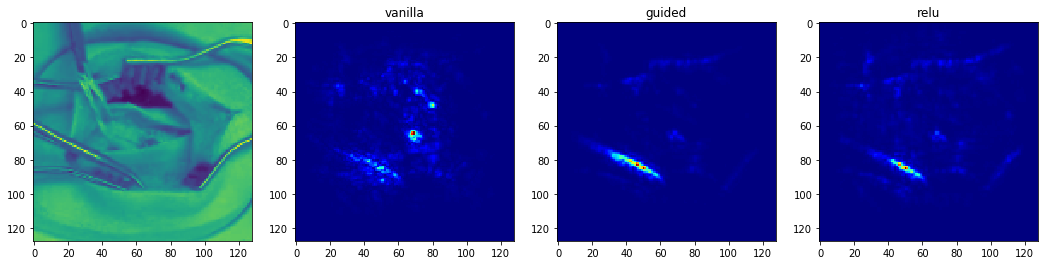

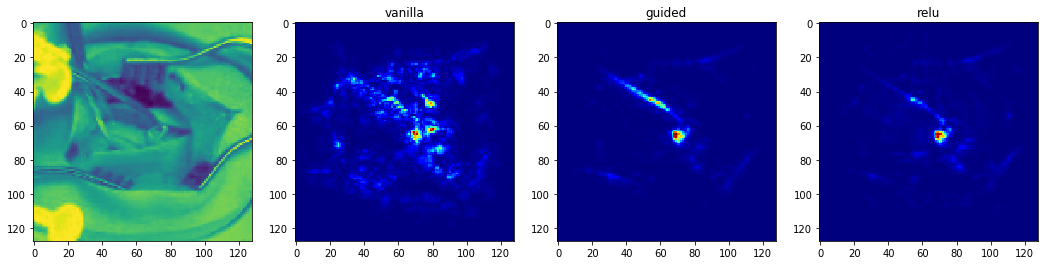

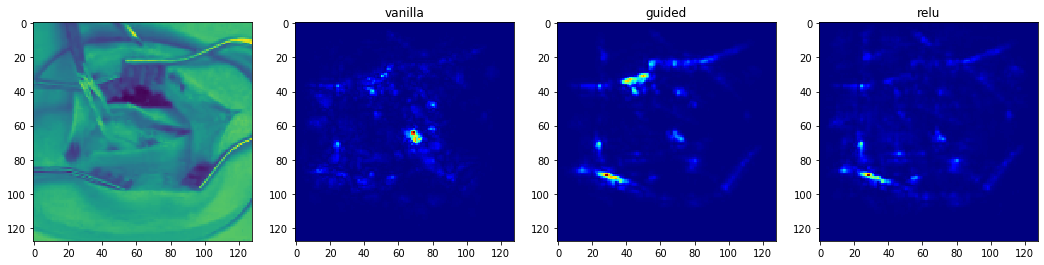

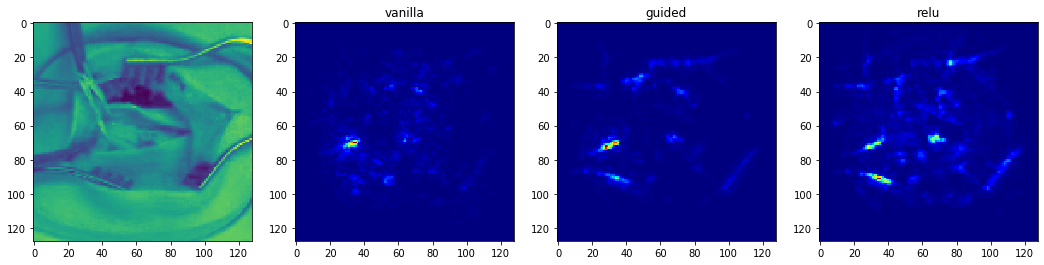

In [15]:
for class_idx in np.arange(len(classes)):
    indices = np.where(val_y[:, class_idx] ==1.0)[0]
    idx = indices[0]
    
    f, ax = plt.subplots(1,4)
    ax[0].imshow(val_x[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                                  seed_input=val_x[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)
        ax[i+1].imshow(grads, cmap = 'jet')

In [16]:
from vis.visualization import visualize_saliency
n_images= 5
start_index = 5
heat_map = np.zeros((n_images, resized_image_size, resized_image_size), dtype = int)
print(heat_map.shape)
#test_generator.reset()
for i in range(n_images//batch_size):
    x, y = test_generator.__getitem__(i)
    heat_map[i][:,:] = visualize_cam(model, 14, None, x[i][:,:,:])
#print(heat_map)
#cplots(heat_map[:n_images], figsize=(20,5), rows=1)
#cplots(heat_map[:n_images], figsize=(20,5), rows=1)

(5, 128, 128)


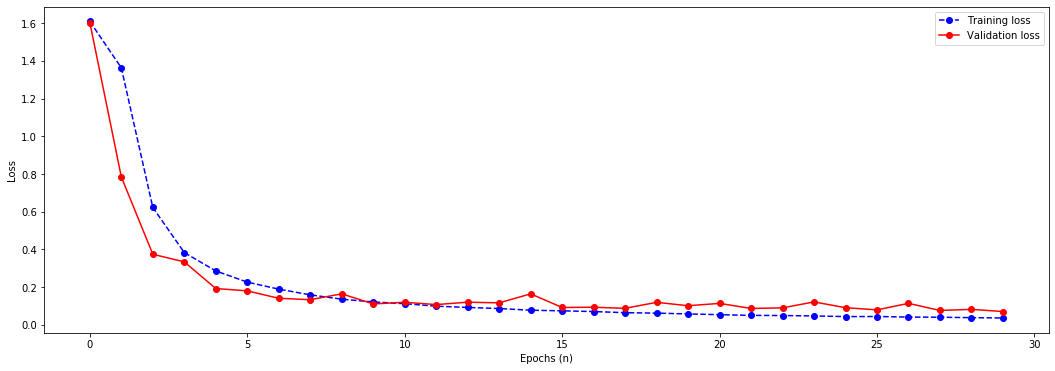

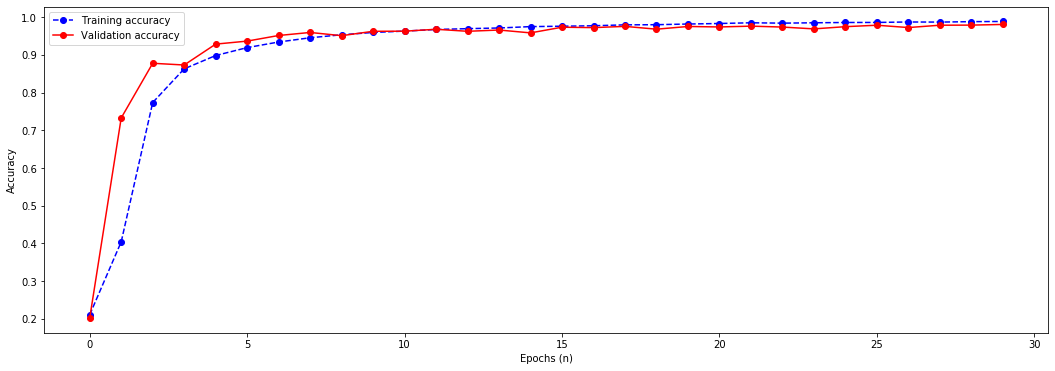

In [17]:
# graphical results

plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['acc'], 'bo--')
plt.plot(history.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [18]:
import time
time.sleep(10)

In [19]:
# save the results and model

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if not os.path.exists(model_save_folder):
    os.makedirs(model_save_folder)
    print("Creating folder: {}".format(model_save_folder))

model_file_name = "model_" + timestamp + ".h5"
model_file_fullname = os.path.join(model_save_folder, model_file_name)

model.save(model_file_fullname)
print("Model saved to: {}".format(model_file_fullname))

notebook_file_name = "notebook_" + timestamp + ".html"
notebook_file_fullpath = os.path.join(notebook_save_folder, notebook_file_name)

if not os.path.exists(notebook_save_folder):
    os.makedirs(notebook_save_folder)
    print("Creating folder: {}".format(notebook_save_folder))


Model saved to: C:\Users\PerkLab\Desktop\HerniaAnnotationSavedModels\model_2019-11-01_14-41-40.h5


In [20]:
time.sleep(10)

# IPython.notebook.save_notebook()

In [21]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [22]:
os.system("jupyter nbconvert --to html TrainTissueDetectionModel-NoNone.ipynb --output " + notebook_file_fullpath)

print("Notebook saved to: {}".format(notebook_file_fullpath))

Notebook saved to: C:\Users\PerkLab\Desktop\HerniaAnnotationSavedNotebooks\notebook_2019-11-01_14-41-40.html
